<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/master/EVA4S5_suman_code1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


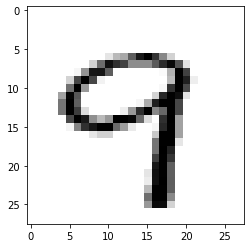

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

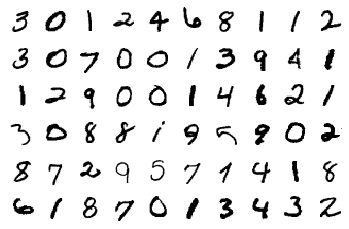

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #drpout = nn.Dropout(0.1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,8,3,bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #drpout
        )# OP-26   RF-3
        self.layer2 = nn.Sequential(
            nn.Conv2d(8,16,3,bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #drpout
        ) # OP-24  RF-5
        self.layer3_MP= nn.MaxPool2d(2,2) #OP-12  RF-6
        self.layer4 = nn.Sequential(		
            nn.Conv2d(16,16,3,bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            #drpout
        ) # OP-10	RF-10
        
        self.layer5 = nn.Sequential(		
            nn.Conv2d(16,16,3,bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            #drpout
        ) # OP-8  RF-14
        self.layer6 = nn.Sequential(
            nn.Conv2d(16,16,3),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            #drpout
        ) # OP-6  RF-18
        self.layer7 = nn.Sequential(
            nn.Conv2d(16,16,3,bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            #drpout
        ) #op-4 RF-22
        '''self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=2)
        )''' 
        self.layer8 = nn.Sequential(
            nn.Conv2d(16,10,1,bias=False),
            nn.ReLU()
        ) #op-4 RF-22
        self.layer9 = nn.Sequential(
            nn.Conv2d(10,10,4,bias=False)
            #nn.ReLU()
        )#op-1 RF-28

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3_MP(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6           [-1, 16, 10, 10]           2,304
              ReLU-7           [-1, 16, 10, 10]               0
            Conv2d-8             [-1, 16, 8, 8]           2,304
              ReLU-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 16, 6, 6]           2,320
             ReLU-11             [-1, 16, 6, 6]               0
           Conv2d-12             [-1, 16, 4, 4]           2,304
             ReLU-13             [-1, 16, 4, 4]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.6332266330718994 Batch_id=468 Accuracy=19.37: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5344, Accuracy: 8427/10000 (84.27%)

EPOCH: 2


Loss=0.2193877249956131 Batch_id=468 Accuracy=90.54: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1537, Accuracy: 9534/10000 (95.34%)

EPOCH: 3


Loss=0.05106401816010475 Batch_id=468 Accuracy=95.77: 100%|██████████| 469/469 [00:10<00:00, 44.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1051, Accuracy: 9684/10000 (96.84%)

EPOCH: 4


Loss=0.07611078023910522 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:10<00:00, 45.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9733/10000 (97.33%)

EPOCH: 5


Loss=0.07286367565393448 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:10<00:00, 45.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9827/10000 (98.27%)

EPOCH: 6


Loss=0.03858591988682747 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:10<00:00, 44.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9818/10000 (98.18%)

EPOCH: 7


Loss=0.012234032154083252 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:10<00:00, 44.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9849/10000 (98.49%)

EPOCH: 8


Loss=0.04355844482779503 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9837/10000 (98.37%)

EPOCH: 9


Loss=0.03517824038863182 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 45.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9864/10000 (98.64%)

EPOCH: 10


Loss=0.01423807442188263 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 45.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9858/10000 (98.58%)

EPOCH: 11


Loss=0.03559349104762077 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 45.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.05293935537338257 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 44.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.051385361701250076 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 44.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9886/10000 (98.86%)

EPOCH: 14


Loss=0.04924739524722099 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:10<00:00, 45.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9876/10000 (98.76%)

EPOCH: 15


Loss=0.011975407600402832 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:10<00:00, 45.06it/s]



Test set: Average loss: 0.0327, Accuracy: 9902/10000 (99.02%)



Text(0.5, 1.0, 'Test Accuracy')

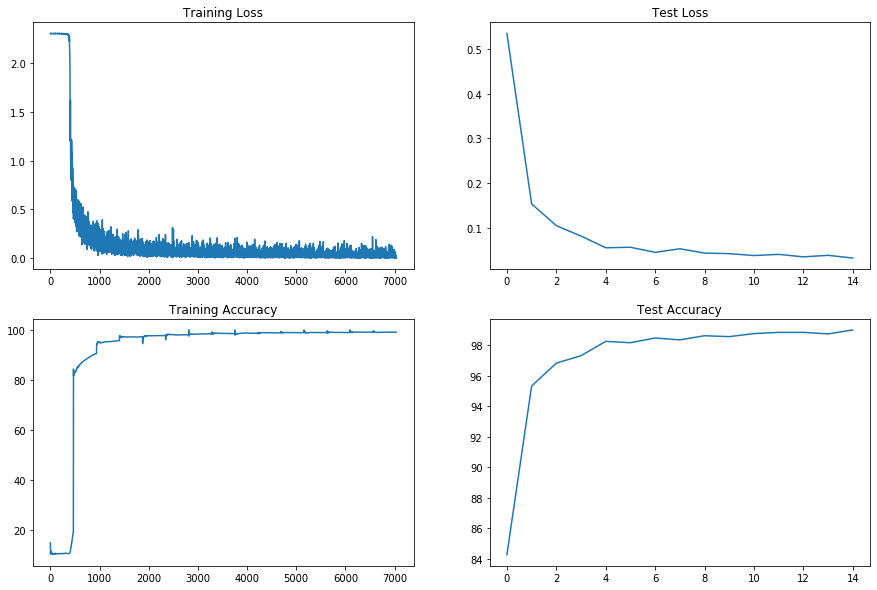

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")